## Sentiment analysis of replies to customer support tweets

The goal of the project is to see whether it is possible to predict the sentiment of replies to customer support tweets based solely on the text of said customer support tweet.

First we explore the "Customer Support on Twitter" dataset retrieved from Kaggle (https://www.kaggle.com/thoughtvector/customer-support-on-twitter) and determine which company's tweets we will use for the analysis (in this case Spotify).

Next, we train and test a naive Bayes classifier on the NLTK tweets samples dataset with the purpose to classify positive and negative tweets. We'll use this classifier to generate labels for the target variable (sentiment) in our customer tweets dataset.

Finally, we train a new naive Bayes classifier on the text of the customer support tweets and use it to predict the sentiment of the replies to these support tweets.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re, string, random
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk import FreqDist, classify, NaiveBayesClassifier

%matplotlib inline
sns.set_style("darkgrid", {'axes.facecolor': '#d9d9d9', 'figure.facecolor': 'None'})
pd.set_option('display.max_colwidth', -1)
sns.set(rc={'figure.figsize':(20,10)}, font_scale=1.5)

In [2]:
tweets = pd.read_csv("twcs.csv")
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
tweet_id                   int64
author_id                  object
inbound                    bool
created_at                 object
text                       object
response_tweet_id          object
in_response_to_tweet_id    float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


In [3]:
# Make sure the variables have appropriate types
tweets["tweet_id"] = tweets["tweet_id"].astype(str) 
tweets["in_response_to_tweet_id"] = tweets["in_response_to_tweet_id"].astype(str).str.strip(".0")
tweets["text"] = tweets["text"].str.lower() # Make all letters in tweet text lower cased

In [4]:
tweets.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 i understand. i would like to assist you. we would need to get you into a private secured link to further assist.,2,3
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare i have sent several private messages and no one is responding as usual,1,4
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 please send us a private message so that we can further assist you. just click ‘message’ at the top of your profile.,3,5
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare i did.,4,6


Text(0.5, 1.0, '20 Most Prolific Customer Support Twitter Accounts')

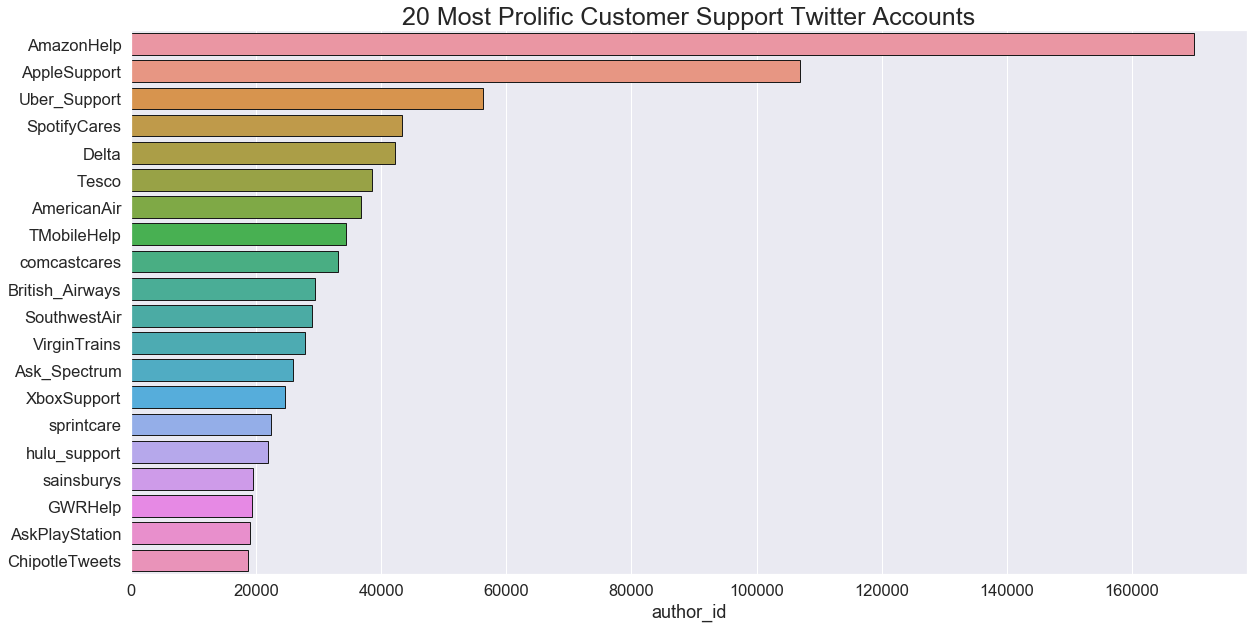

In [24]:
# Visualize the 20 most prolific customer support Twitter accounts
g = sns.barplot(x = tweets['author_id'].value_counts()[:20],
                y = tweets['author_id'].value_counts()[:20].index,
                orient = "h", edgecolor = 'k')
g.set_title('20 Most Prolific Customer Support Twitter Accounts', size = 25)

In [6]:
# Extract tweets by and send to the Spotify customer service account
# SpotifyCares has enough tweets for analysis without making it needlessly slow + they are in English
tweetsSpot = tweets[(tweets["author_id"] == "SpotifyCares") | (tweets["text"].str.contains("@spotifycares"))]

## Text processing and sentiment analysis

The original code for the text processing and sentiment analysis is written by Shaumik Daityari and can be found in his excellent blog post on sentiment analysis using the Natural Language Toolkit (NLTK): https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk

### Defining functions for text processing

In [7]:
# A function to remove noise ("@", hyperlinks) from tweets, lemmatize the words and remove stopwords
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [8]:
# In order to feed the tweets into the naive Bayes classifier their text needs to be in a dictionary format with the tokens as keys and "True" as values
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

In [9]:
# Here we actually process the text of the sample tweets by using the functions above.

# Retrieve positive and negative tweets from NLTK tweet samples
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

default_stop_words = stopwords.words('english') # A dictionary with English stopwords
keep_words = ["no", "nor", "not"] # Remove these words from the stop_words list
stop_words = [word for word in default_stop_words if word not in keep_words]

# Tokenize the tweets
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

# Use the remove_noise function to clean the lists of tokens
for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

# Convert the lists of tokens into the right format required for the classifier 
positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

# Compile the complete dataset by adding the positive and negative datasets
dataset = positive_dataset + negative_dataset

# Randomize the order of the rows in the dataset to avoid bias
random.seed(7)
random.shuffle(dataset)

# Split the complete dataset into a train and test set according to a 70/30 split
train_data = dataset[:7000]
test_data = dataset[7000:]

# Train the naive Bayes classifier on the training data
classifier = NaiveBayesClassifier.train(train_data)

# Print the accuracy of the classifier after testing it on the test data
print("Accuracy is:", classify.accuracy(classifier, test_data))

# Print the most informative features of the model
print(classifier.show_most_informative_features(10))

# Assemble the predictions and reference labels of the test set to print out a confusion matrix
predictions = []
references = []

for i in range(len(test_data)):
    predictions.append(classifier.classify(test_data[i][0]))
    references.append(test_data[i][1])
    
CM = nltk.ConfusionMatrix(references, predictions)
print("Confusion Matrix:")
print(CM)

Accuracy is: 0.996
Most Informative Features
                      :( = True           Negati : Positi =   2037.8 : 1.0
                      :) = True           Positi : Negati =   1680.0 : 1.0
                     sad = True           Negati : Positi =     35.4 : 1.0
                follower = True           Positi : Negati =     29.0 : 1.0
                 welcome = True           Positi : Negati =     18.6 : 1.0
               community = True           Positi : Negati =     17.4 : 1.0
                    glad = True           Positi : Negati =     15.3 : 1.0
                    damn = True           Negati : Positi =     14.7 : 1.0
                followed = True           Negati : Positi =     14.3 : 1.0
                 awesome = True           Positi : Negati =     12.9 : 1.0
None
Confusion Matrix:
         |    N    P |
         |    e    o |
         |    g    s |
         |    a    i |
         |    t    t |
         |    i    i |
         |    v    v |
         |    e    e 

In [10]:
# GENERATE TARGET LABELS ON SPOTIFY TWEETS

# Retrieve the text of the tweets from and to the Spotify customer service account
content_tweets = tweetsSpot['text'].reset_index().text

# Tokenize the tweets
tweet_tokenizer = TweetTokenizer()
tweet_tokens = []
for tweet in content_tweets:
    tweet_tokens.append(tweet_tokenizer.tokenize(tweet))

# Clean the list of tokens by using the remove noise function    
cleaned_tokens_list = []

for tokens in tweet_tokens:
    cleaned_tokens_list.append(remove_noise(tokens, stop_words))
    
    
# Convert the list of tokens into the right format for the classifier
tokens_for_model = get_tweets_for_model(cleaned_tokens_list)

Spot_dataset = [(tweet_dict) for tweet_dict in tokens_for_model]

# Determine the sentiment of each tweet by using the naive Bayes classifier developed earlier
sentiment = []
for cleaned_tweet in Spot_dataset:
    sentiment.append(classifier.classify(cleaned_tweet))

tweets_sen = pd.concat([content_tweets, pd.Series(sentiment)], axis=1).rename(columns={0:"sentiment"})

tweets_sen.head(5)

,text,sentiment
0,@115887 hmm. can you try restarting your device by holding the sleep/wake + volume down buttons for 10 seconds? keep us posted /ls,Positive
1,@spotifycares doesn’t work and i even tried deleting the app,Negative
2,@115887 could you send us a dm with your account's email address? we'll take a look backstage /ch https://t.co/ldfdzrinat,Positive
3,@spotifycares premium &amp; when i️ have it on shuffle it turns off when the song is done and just plays in order and the repeat lights up but doesn’t repeat,Negative
4,"@115887 thanks. just to be sure, are you free or premium? also, can you give us more info on what happens when you try using it? /cb",Positive


In [11]:
# Add the sentiment to the original Spotify tweets dataset
tweetsSpot = tweetsSpot.merge(tweets_sen, on = ["text"], how = "left")

In [12]:
tweetsSpot

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,sentiment
0,848,SpotifyCares,False,Tue Oct 31 22:28:16 +0000 2017,@115887 hmm. can you try restarting your device by holding the sleep/wake + volume down buttons for 10 seconds? keep us posted /ls,849,85,Positive
1,849,115887,True,Tue Oct 31 23:36:20 +0000 2017,@spotifycares doesn’t work and i even tried deleting the app,851,848,Negative
2,851,SpotifyCares,False,Tue Oct 31 23:39:03 +0000 2017,@115887 could you send us a dm with your account's email address? we'll take a look backstage /ch https://t.co/ldfdzrinat,NaN,849,Positive
3,850,115887,True,Tue Oct 31 21:41:37 +0000 2017,@spotifycares premium &amp; when i️ have it on shuffle it turns off when the song is done and just plays in order and the repeat lights up but doesn’t repeat,848,852,Negative
4,852,SpotifyCares,False,Tue Oct 31 21:04:13 +0000 2017,"@115887 thanks. just to be sure, are you free or premium? also, can you give us more info on what happens when you try using it? /cb",850,853,Positive
...,...,...,...,...,...,...,...,...
96035,2987400,SpotifyCares,False,Thu Nov 30 07:29:24 +0000 2017,@823709 hey benedict! can you dm us yours and your family members' accounts' email addresses or usernames? we'll take a look /ns https://t.co/ldfdzrinat,NaN,2987401,Positive
96036,2987401,823709,True,Thu Nov 30 07:20:48 +0000 2017,"@spotifycares hey guys, my family members cannot seem to be added to the familly subscription. i have re-nominated them but it doesnt work.",2987400,nan,Positive
96037,65997,131099,True,Thu Nov 30 07:48:10 +0000 2017,@spotifycares my email address is __email__. screenshot of email received enclosed.,NaN,65996,Positive
96038,2987684,SpotifyCares,False,Tue Oct 31 22:03:05 +0000 2017,"@823786 hey paul! could you dm us your account's username or email address, as well as your wife's? we'll take a look under the hood /gu https://t.co/ldfdzrinat",NaN,2987685,Positive


Text(0.5, 1.0, 'Sentiment of Spotify Customer Service Tweets and Replies over Time')

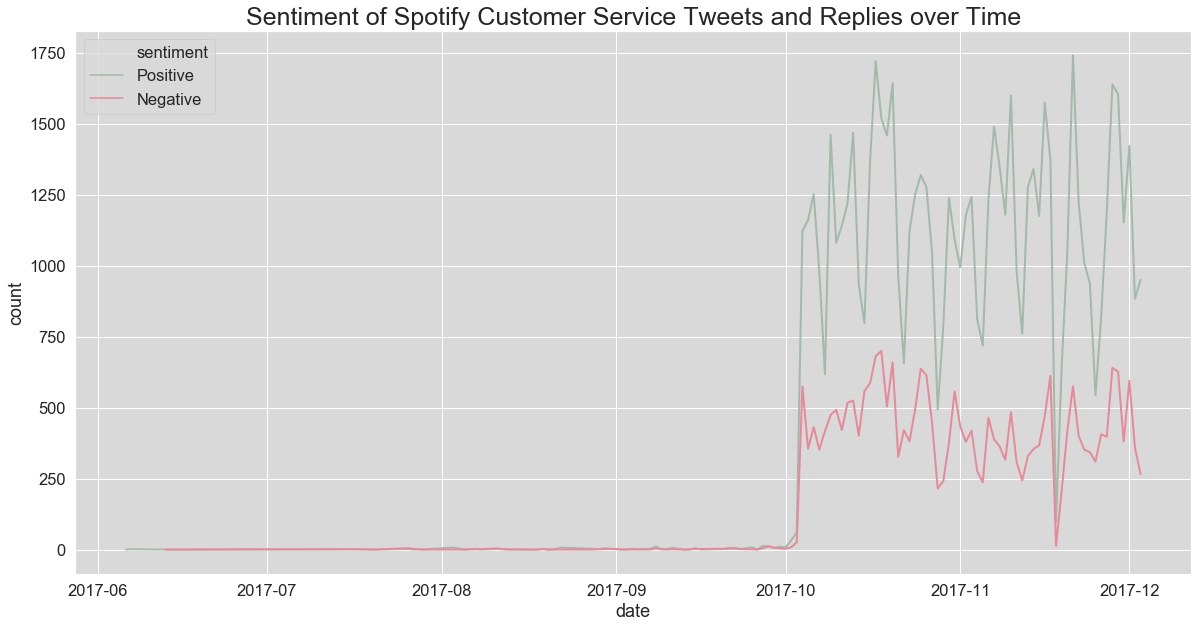

In [25]:
# Add a 'date' variable in the appropriate format for visualization purposes

tweetsSpot['created_at'] = pd.to_datetime(tweetsSpot['created_at'], format = '%a %b %d %X %z %Y')
tweetsSpot['date'] = tweetsSpot['created_at'].dt.date
startdate = pd.to_datetime("2017-06-01").date() # Initialize a start-date for the visualization

visData = tweetsSpot[['date','sentiment','tweet_id']][tweetsSpot['date'] > startdate].groupby(['date','sentiment']).agg('count').unstack()
visData.columns = visData.columns.droplevel(0)
tidyvisData = visData.stack().reset_index().rename(columns={0:'count'})

sns.set_style("darkgrid", {'axes.facecolor': '#d9d9d9', 'figure.facecolor': 'None'})
g = sns.lineplot(data = tidyvisData, x = "date", y = 'count', hue = 'sentiment', palette = ['#A3B9AA','#E68A99'], linewidth = 2)
g.set_title('Sentiment of Spotify Customer Service Tweets and Replies over Time', size = 25)

## Predict sentiment of tweets in reply to Spotify customer service tweets

In [14]:
# Extract tweets that were in response to a @SpotifyCares tweet
tweet_ids_by_Spotify = list(tweetsSpot["tweet_id"][tweetsSpot["author_id"] == "SpotifyCares"])
replyTweets = tweetsSpot[tweetsSpot["in_response_to_tweet_id"].isin(tweet_ids_by_Spotify)].drop_duplicates(keep='first')
replyTweets.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,sentiment,date
1,849,115887,True,2017-10-31 23:36:20+00:00,@spotifycares doesn’t work and i even tried deleting the app,851,848,Negative,2017-10-31
3,850,115887,True,2017-10-31 21:41:37+00:00,@spotifycares premium &amp; when i️ have it on shuffle it turns off when the song is done and just plays in order and the repeat lights up but doesn’t repeat,848,852,Negative,2017-10-31
5,853,115887,True,2017-10-31 19:57:59+00:00,@spotifycares iphone 7+ and i have the most recent update for spotify,852,854,Positive,2017-10-31
8,857,115889,True,2017-11-01 07:40:06+00:00,"@spotifycares yes, multiple times. no changes. i am premium user an when @115890 send us users to spotify there should be a bugfree running app 🤨",859,856,Positive,2017-11-01
14,864,115891,True,2017-10-31 22:22:05+00:00,@spotifycares ok thx,863,865,Positive,2017-10-31


In [15]:
# Create a dataset in which the replies to the customer service tweets are merged with the original customer service tweets
RepOrgTweets = replyTweets.merge(tweetsSpot, how = "left", left_on = ["in_response_to_tweet_id"], right_on = ["tweet_id"])

Text(0.5, 1.0, 'Sentiment Distribution of Replies to Customer Service Tweets')

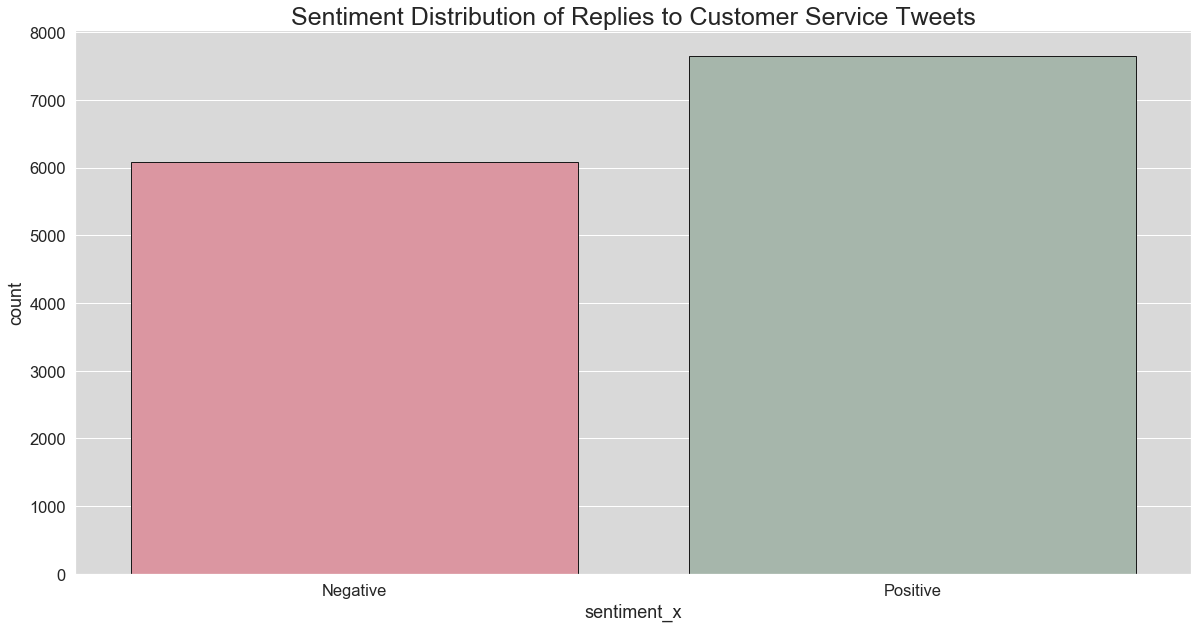

In [26]:
# Distribution of positive & negative tweets for replies to customer service tweets
g = sns.countplot(RepOrgTweets["sentiment_x"], edgecolor = 'k', palette = ['#E68A99','#A3B9AA'])
g.set_title('Sentiment Distribution of Replies to Customer Service Tweets', size = 25)

In [17]:
# Remove unnecessary features
RepOrgTweets = RepOrgTweets.drop(["inbound_x", "inbound_y", "created_at_x", "created_at_y",
                                  "response_tweet_id_x", "response_tweet_id_y",
                                  "in_response_to_tweet_id_x", "in_response_to_tweet_id_y",
                                  "sentiment_y", "date_x", "date_y"], axis = 1)

RepOrgTweets.head(5)

,tweet_id_x,author_id_x,text_x,sentiment_x,tweet_id_y,author_id_y,text_y
0,849,115887,@spotifycares doesn’t work and i even tried deleting the app,Negative,848,SpotifyCares,@115887 hmm. can you try restarting your device by holding the sleep/wake + volume down buttons for 10 seconds? keep us posted /ls
1,850,115887,@spotifycares premium &amp; when i️ have it on shuffle it turns off when the song is done and just plays in order and the repeat lights up but doesn’t repeat,Negative,852,SpotifyCares,"@115887 thanks. just to be sure, are you free or premium? also, can you give us more info on what happens when you try using it? /cb"
2,853,115887,@spotifycares iphone 7+ and i have the most recent update for spotify,Positive,854,SpotifyCares,"@115887 hey! what device, operating system, and spotify version are you using? we'll see what we can suggest /cb"
3,857,115889,"@spotifycares yes, multiple times. no changes. i am premium user an when @115890 send us users to spotify there should be a bugfree running app 🤨",Positive,856,SpotifyCares,"@115889 got it. it's not possible at the moment, but we'll pass on the the suggestion. could you try reinstalling the app? /pb"
4,864,115891,@spotifycares ok thx,Positive,865,SpotifyCares,"@115891 hey mikey! we're afraid there's no way to filter or search that way, but we'll pass that suggestion on to the relevant folks /gs"


In [18]:
# Only keep the features required for the sentiment prediction (customer service tweets & sentiment of reply)
ModelTweets = RepOrgTweets.drop(["tweet_id_x", "tweet_id_y", "author_id_x", "author_id_y", "text_x"], axis = 1)

In [19]:
# Separate the customer service tweets that illicited a positive response and the ones that illicited a negative response
positive_tweets = ModelTweets["text_y"][ModelTweets["sentiment_x"] == "Positive"]
negative_tweets = ModelTweets["text_y"][ModelTweets["sentiment_x"] == "Negative"]

default_stop_words = stopwords.words('english') # A dictionary with English stopwords
keep_words = ["no", "nor", "not"] # Remove these words from the stop_words list
stop_words = [word for word in default_stop_words if word not in keep_words]

# Initialize tweet tokenizer
tweet_tokenizer = TweetTokenizer()

# Tokenize the tweets
positive_tweet_tokens = []
negative_tweet_tokens = []

for tweet in positive_tweets:
    positive_tweet_tokens.append(tweet_tokenizer.tokenize(tweet))

for tweet in negative_tweets:
    negative_tweet_tokens.append(tweet_tokenizer.tokenize(tweet))        

# Clean the list of tokens by using the remove_noise function
positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))


# Convert the lists of tokens into the right format required for the classifier 
positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]


dataset = positive_dataset + negative_dataset

random.seed(7)
random.shuffle(dataset)

# Create a 70/30 train/test split
train_data = dataset[:round(len(dataset) * 0.70)]
test_data = dataset[round(len(dataset) * 0.70):]

# Train the naive Bayes classifier
classifier = NaiveBayesClassifier.train(train_data)

# Print the accuracy, most informative features and confusion matrix
print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

predictions = []
references = []

for i in range(len(test_data)):
    predictions.append(classifier.classify(test_data[i][0]))
    references.append(test_data[i][1])


CM = nltk.ConfusionMatrix(references, predictions)
print("Confusion Matrix:")
print(CM)  

Accuracy is: 0.623695071619325
Most Informative Features
                     3/4 = True           Negati : Positi =      6.9 : 1.0
          cache-clearing = True           Negati : Positi =      6.9 : 1.0
                       9 = True           Negati : Positi =      5.8 : 1.0
              submission = True           Positi : Negati =      5.7 : 1.0
                  router = True           Negati : Positi =      5.6 : 1.0
                      jj = True           Negati : Positi =      5.3 : 1.0
                  manage = True           Positi : Negati =      5.2 : 1.0
                     129 = True           Negati : Positi =      5.1 : 1.0
                  really = True           Negati : Positi =      5.1 : 1.0
                   queue = True           Negati : Positi =      5.1 : 1.0
None
Confusion Matrix:
         |    N    P |
         |    e    o |
         |    g    s |
         |    a    i |
         |    t    t |
         |    i    i |
         |    v    v |
         